In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-11-2022)' )

loaded gammapy version: 0.1.dev19056+g5a5f803 
Supposed to be 1.0 (21-11-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map

from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets#, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    #PowerLawNuisanceSpectralModel,
    #PowerLawNormNuisanceSpectralModel
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

sys.path.append('/home/katrin/Documents/nuisance_summary/')
from Dataset_Creation import sys_dataset
import Dataset_load 

## Read dataset

In [3]:
dataset_asimov = Dataset_load.create_asimov()

## Single Cases

In [4]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
zero = 1e-24

bias = 0.0
bias_assumed = 0.1

shift = 0
tilt = 0
shift_assumed = zero
tilt_assumed = zero

print(tilt)
sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift, 
                        tilt = tilt,
                        resolution = 0,
                        bias = bias,
                        e_reco_creation = 10, 
                        rnd = False)
dataset = sys_.create_dataset()
dataset.models[0].parameters['lon_0'].frozen = True
dataset.models[0].parameters['lat_0'].frozen = True
datasets = Datasets(dataset)    
    
    
dataset_N = sys_.create_dataset_N(10)
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
np.fill_diagonal(penalising_invcovmatrix,
                 [1/bias_assumed**2, 1/zero**2, 1/shift_assumed**2, 1/tilt_assumed**2])

dataset_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_N.models[0].parameters['lon_0'].frozen = True
dataset_N.models[0].parameters['lat_0'].frozen = True
dataset_N.models.parameters['norm_nuisance'].frozen = True
dataset_N.models.parameters['tilt_nuisance'].frozen = True
dataset_N.models.parameters['resolution'].frozen = True

datasets_N = Datasets(dataset_N)

parlist= ['norm', 'tilt', 'sigma']
for p in parlist:
    datasets.models.parameters[p].frozen = True    
    datasets_N.models.parameters[p].frozen = True
    


0
bias: 0.0
bias: 0.0


In [5]:
print(datasets_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : Source
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.300   +/-    0.00             
    amplitude                     :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):     83.631       deg         
    lat_0                 (frozen):     22.018       deg         
    sigma                 (frozen):      0.019       deg         
    e                     (frozen):      0.000                   
    phi                   (frozen):      0.000       deg         

Component 1: FoVBackgroundModel

  Name                      : dataset N-bkg
  Datasets names            : ['dataset N']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
   

In [6]:
import json

def make_writeable(cc):
    d = dict()
    for ii, seg in enumerate(cc.allsegs[0]):
        d['x'] = seg[:,0].tolist()
        d['y'] = seg[:,1].tolist()
    return d

def save(c, name):
    d = make_writeable(c)
    with open(name, 'w') as f:
        json.dump(d, f)
        
def read(name):
    with open(name) as data_file:
        data_loaded = json.load(data_file)
    return data_loaded

## Standard 

In [7]:
%%time
fitting = False
if fitting :
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.01, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(datasets)
    print(result)
    dd
    c = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                                   cl = 0.68, 
                                   size = 100, 
                                   )
    save(c, 'data/5_scan_68.json')
    c95 = fit.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                                   cl = 0.95, 
                                   size = 100, 
                                   )
    save(c95, 'data/5_scan_95.json')
else:
    c = read('data/5_scan_68.json')
    c95 = read('data/5_scan_95.json')


CPU times: user 187 µs, sys: 174 µs, total: 361 µs
Wall time: 249 µs


-753580.0869834921
-753531.3962141147
-753396.6192744419
-753579.2322649241
-753579.0819081638
-753579.9189116536
-753579.8964026852
-753540.4949581586
-753530.3220816255
-753579.6683125736
-753579.6263360169
-753579.9189341038
-753579.8957310577
-753580.0869834921
-753579.9189116536
-753579.8964026852
-753579.9189341038
-753579.8957310577
-753580.0810634007
-753580.0785637372
-753580.0869386639
-753580.0864547389
-753580.0818773909
-753580.0777184092
-753580.0871100472
-753580.0862821089
-753580.0024554944
-753580.0876514141
-753580.08765347
-753580.0594295079
-753580.0586430919
-753580.0590353366
-753580.0589740623
-753580.08765347
-753580.0594295079
-753580.0586430919
-753580.0590353366
-753580.0589740623
-753580.0865235655
-753580.0864941406
-753580.0876101123
-753580.0876052524
-753580.0876521133
-753580.0876511531
-753580.086498329
-753580.0865167207
-753580.087605664
-753580.0876095875
-753580.087651239
-753580.0876520278
-753580.0714932992
-753580.08765347
-753570.2537567322
-7

-753579.8617321465
-753579.7026879785
-753579.6693454245
-753579.8620714997
-753579.8620717269
-753579.862072933
-753579.683802346
-753579.6813310978
-753579.862072933
-753579.683802346
-753579.6813310978
-753579.8549028796
-753579.8548833397
-753579.8617857946
-753579.8617856812
-753579.8620614419
-753579.8620614572
-753579.8620724748
-753579.8620724799
-753579.3559145266
-753579.7158764203
-753578.2992422343
-753579.6837784315
-753578.6687367735
-753579.7151785437
-753579.5673025933
-753579.5135908241
-753579.7161211492
-753579.7161205297
-753579.5371602632
-753579.5362987898
-753579.7161211492
-753579.5371602632
-753579.5362987898
-753579.7087957545
-753579.7090960734
-753579.7158022171
-753579.7158660656
-753579.7161032688
-753579.7161160698
-753579.0090431815
-753579.5140882055
-753577.813509207
-753579.4416348885
-753578.2171373069
-753579.5326770055
-753579.534707834
-753579.3677107019
-753579.3547533401
-753579.5347469077
-753579.5347480325
-753579.5347485072
-753579.3563648721

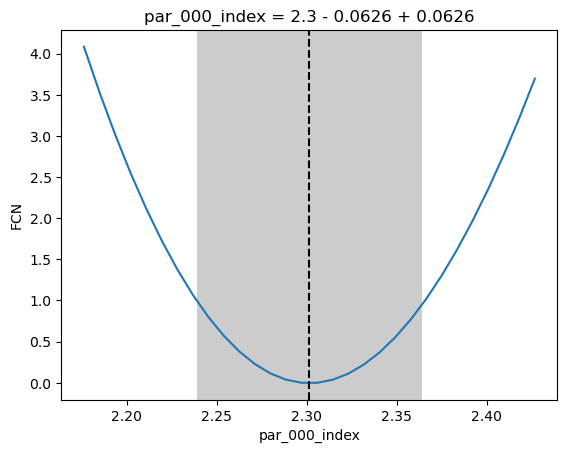

In [8]:
scanning = True
if scanning :
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.01, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit.run(datasets)
    scan_index = fit.minuit.draw_mnprofile('par_000_index')    
    


-753571.6100937456
-753569.1737961525
-753573.5712827495
-753569.5158417854
-753573.3451155864
-753575.7827824594
-753575.8205628521
-753575.899974165
-753575.6199059896
-753575.5949909217
-753575.7268910396
-753575.7138232572
-753575.8999122856
-753575.899973718
-753575.8999768712
-753575.7254680356
-753575.7152757884
-753575.8999400935
-753575.8999726961
-753575.8999760658
-753575.8999766712
-753575.8999768097
-753575.8999768491
-753575.8999768617
-753575.8999768633
-753575.8999768696
-753575.8999768654
-753575.8999768712
-753575.7254680356
-753575.7152757884
-753575.8928280412
-753575.8927633739
-753575.8996882059
-753575.8996910553
-753575.8999650341
-753575.8999657258
-753575.8999763431
-753575.8999764838
-753574.716484826
-753572.6568367847
-753576.252233265
-753573.0448552398
-753576.0289051386
-753577.3976470141
-753577.4182677579
-753577.4446542258
-753577.1939698702
-753577.1712411917
-753577.2720683918
-753577.2579789229
-753577.444599641
-753577.4446569083
-753577.444659191

-753577.689117077
-753577.6891174824
-753577.6891174994
-753572.3672877122
-753574.5526803422
-753569.1905260435
-753573.7947792639
-753570.5806477508
-753576.3072040612
-753576.3728088546
-753576.3088237015
-753576.1854722723
-753576.2684450345
-753576.1177886301
-753576.379591115
-753576.2158870341
-753576.1894205734
-753576.3796460901
-753576.379681824
-753576.3796824296
-753576.2056839417
-753576.1950645281
-753576.3796424549
-753576.3796780119
-753576.3796816138
-753576.3796822561
-753576.3796823884
-753576.3796824268
-753576.3796824287
-753576.3796824357
-753576.2053208847
-753576.1947118246
-753576.3795232694
-753576.3796724468
-753576.3796808021
-753576.3796820776
-753576.3796823409
-753576.3796824098
-753576.3796824233
-753576.3796824347
-753576.3796824361
-753576.3796824322
-753576.3796824343
-753576.3796824357
-753576.2053208847
-753576.1947118246
-753576.3725371186
-753576.3724610496
-753576.3793945317
-753576.3793956786
-753576.3796707566
-753576.3796711206
-753576.3796819

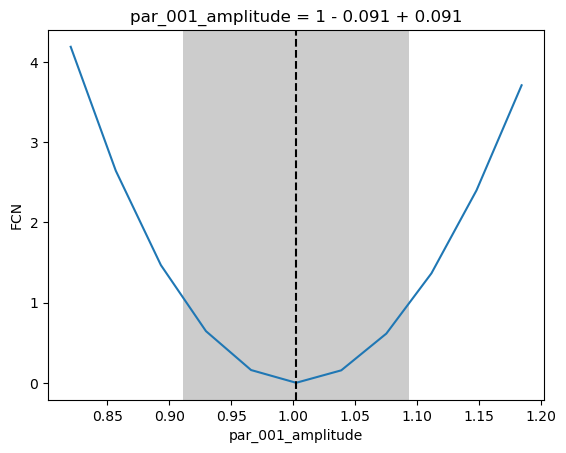

In [9]:
if scanning :
    scan_amplitude = fit.minuit.draw_mnprofile('par_001_amplitude' , size = 11)       


## Nuisance Parameters

In [10]:
%%time 
scan =1
if scan :
    fit_N = Fit(store_trace=False)
    minuit_opts = {"tol": 0.01, "strategy": 2}
    fit.optimize_opts = minuit_opts
    result = fit_N.run(datasets_N)
    #scan_index_N = fit_N.minuit.draw_mnprofile('par_000_index', size = 11)    
    

bias: 0.0
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0. 0. 0. 0.]
res: 0.0
-753580.0869834921
bias: 0.0
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0. 0. 0. 0.]
res: 0.0
-753531.3962141147
bias: 0.0
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0. 0. 0. 0.]
res: 0.0
-753396.6192744419
bias: 0.0
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0. 0. 0. 0.]
res: 0.0
-753579.2322649241
bias: 0.0
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0. 0. 0. 0.]
res: 0.0
-753579.0819081638
bias: 0.0
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e

[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.00129247 0.         0.         0.        ]
res: 0.00016704756102361738
-753580.0872540544
bias: 0.0012679994570339208
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.001268 0.       0.       0.      ]
res: 0.00016078226230383178
-753580.0872541602
bias: 0.0012679994570339208
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.001268 0.       0.       0.      ]
res: 0.00016078226230383178
-753579.9158360673
bias: 0.0012679994570339208
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.001268 0.       0.       0.      ]
res: 0.00016078226230383178
-753579.8993489911
bias: 0.0012679994570339208
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 

[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.001268 0.       0.       0.      ]
res: 0.00016078226230383178
-753580.081421266
bias: 0.0012679994570339208
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.001268 0.       0.       0.      ]
res: 0.00016078226230383178
-753580.0787151224
bias: 0.0012679994570339208
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.001268 0.       0.       0.      ]
res: 0.00016078226230383178
-753580.0872354048
bias: 0.0012679994570339208
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.001268 0.       0.       0.      ]
res: 0.00016078226230383178
-753580.0866980293
bias: 0.00423784485738664
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+

In [11]:
print(dataset_N)

bias: 0.0012679994570339208
bias: 0.0012679994570339208
bias: 0.0012679994570339208
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.001268 0.       0.       0.      ]
res: 0.00016078226230383178
-753580.0872541602
MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 361333 
  Total background counts         : 360331.31
  Total excess counts             : 1001.76

  Predicted counts                : 361332.04
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1000.69

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -753580.09

  Number of models                : 3 
  Number of parameters            : 16
  Numb

In [12]:
%%time
fitting_N = 0
if fitting_N:
    #fit_N = Fit(store_trace=False)
    #minuit_opts = {"tol": 0.01, "strategy": 2}
    #fit.optimize_opts = minuit_opts
    #result = fit_N.run(datasets_N)
    c_N = fit_N.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                               cl = 0.68, 
                              size = 10, 
                              interpolated = True,
                               )
    
    save(c_N, 'data/5_scan_N_68.json')
    print("95")
    c95_N = fit_N.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                               cl = 0.95, 
                               size = 10, 
                               )
    save(c95_N, 'data/5_scan_N_95.json')
else:
    c_N = read('data/5_scan_N_68.json')
    c95_N = read('data/5_scan_N_95.json')

CPU times: user 337 µs, sys: 477 µs, total: 814 µs
Wall time: 633 µs


Test 1:
try cl = 0.3 -> no

cl =  0.99 -> no 

size = 2

index vs bias
amplitude vs bias

cl = 10

In [13]:
fit_N.minuit.parameters

('par_000_index', 'par_001_amplitude', 'par_002_bias')

In [14]:
dataset_N.models.parameters.penalised_parameters.names

['bias', 'resolution', 'norm_nuisance', 'tilt_nuisance']

In [15]:
fit_N.minuit

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -7.536e+05                 │              Nfcn = 83               │
│ EDM = 0.00024 (Goal: 0.0002)     │           time = 20.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name              │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ par_000_index     │   2.30    │   0.08    │            │            │         │         │       │
│ 1 │ par_001_amplitude │    1.0    │    0.1    │            │            │         │         │       │
│ 2 │ par_002_bias      │   0.001   │   0.031   │            │            │         │         │       │
└───┴───────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────┬───────────────────────────────────────────────────────┐
│                   │     par_000_index par_001_amplitude      par_002_bias │
├───────────────────┼───────────────────────────────────────────────────────┤
│     par_000_index │           0.00578           0.00535           0.00138 │
│ par_001_amplitude │           0.00535           0.00913           0.00103 │
│      par_002_bias │           0.00138           0.00103          0.000961 │
└───────────────────┴───────────────────────────────────────────────────────┘

bias: 0.02872128792322303
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.02872129 0.         0.         0.        ]
res: 0.08249123799686771
-753579.0382480983
bias: 0.02872128792322303
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.02872129 0.         0.         0.        ]
res: 0.08249123799686771
-753578.4944221406
bias: 0.02872128792322303
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.02872129 0.         0.         0.        ]
res: 0.08249123799686771
-753579.2822180736
bias: 0.0373933929052159
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [0.03739339 0.         0.         0.        ]
res: 0.13982658329638506
-753578.980912753
bias: 0.020049182941230162
[[1.e+02 0.

[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [-0.02567761  0.          0.          0.        ]
res: 0.0659339709484754
-753578.788227841
bias: -0.025677611054861667
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [-0.02567761  0.          0.          0.        ]
res: 0.0659339709484754
-753578.782866772
bias: -0.006656366362208163
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [-0.00665637  0.          0.          0.        ]
res: 0.004430721314793633
-753578.5500434197
bias: -0.04469885574751517
[[1.e+02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+48 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+48 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+48]] [-0.04469886  0.          0.          0.        ]
res: 0.19979877051371697
-753578.4685614894
bias: -0.013673291802028146
[[1.e+02 0.e+00 

ValueError: zero-size array to reduction operation minimum which has no identity

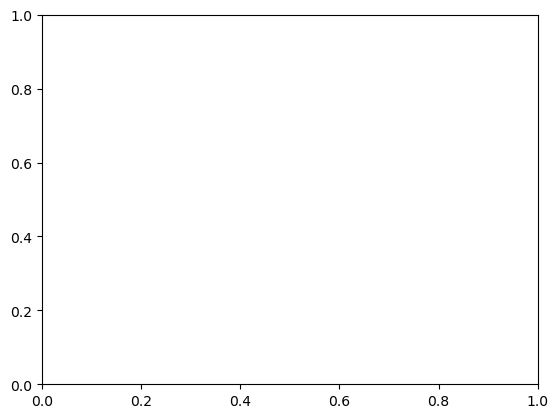

In [16]:
c_N = fit_N.minuit.draw_mncontour("par_000_index", "par_001_amplitude", 
                               cl = 1, 
                              size = 10, 
                              #interpolated = True,
                               )

In [ ]:
datasets.models.parameters.to_table()

In [ ]:
datasets_N.models.parameters.to_table()

# Stat Contours

In [ ]:
color_standard = 'crimson'; color_standard_e = 'palevioletred'
color_nui = 'navy'; color_nui_e = 'cornflowerblue' # 'cornflowerblue'
color_rnd = 'darkgreen'
color_input = 'darkorange'
color_ereco = 'darkorange' ; color_ereco_e = 'gold'

In [ ]:
if not fitting and not fitting_N:

    plt.figure()
    plt.plot(c['x'], c['y'], '.-', label='0.68', color = color_standard)
    plt.plot(c95['x'], c95['y'], '.-', label='0.95', color = color_standard_e)
    plt.plot(c_N['x'], c_N['y'], '.-', label='Ereco 0.68', color = color_ereco)
    plt.plot(c95_N['x'], c95_N['y'], '.-', label='Ereco 0.95', color = color_ereco_e)
    
    plt.legend(fontsize=9, loc='best')

In [ ]:
if fitting:# and fitting_N:

    plt.figure()
    for ii, seg in enumerate(c.allsegs[0]):
        plt.plot(seg[:,0], seg[:,1], '.-', label=c.levels[ii], color = color_standard)
    for ii, seg in enumerate(c95.allsegs[0]):
        plt.plot(seg[:,0], seg[:,1], '.-', label=c95.levels[ii], color = color_standard_e)    


    plt.legend(fontsize=9, loc='best')